In [18]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.layers import GlobalAveragePooling2D,Dropout,BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from scipy.optimize import minimize

In [19]:

def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path)

    train_datagen = ImageDataGenerator(validation_split=0.2)

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    validation_generator = train_datagen.flow_from_directory(
        base_path,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        subset='validation', shuffle=False)

    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator

In [20]:
def trainingarray(train_generator):
    train_array = []

    for image_path in train_generator.filenames:
        img = image.load_img(os.path.join(train_generator.directory, image_path), target_size=(256, 256))
        img = image.img_to_array(img)
        train_array.append(img)
    train_array = np.array(train_array)
    return train_array

In [21]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [22]:
def initiateModel1(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    #x = Dense(128, activation='relu')(x)
    #x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def initiateModel2(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = GlobalAveragePooling2D()(modelInput.output)
    #x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    prediction = Dense(noOfClasses, activation='softmax')(x)
    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [23]:
def initiateModel3(noOfClasses):
    modelInput_vgg16 = tf.keras.applications.VGG16(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    for layer in modelInput_vgg16.layers:
        layer.trainable = False

    # Load and freeze MobileNetV3Small model
    modelInput_mobilenet = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    for layer in modelInput_mobilenet.layers:
        layer.trainable = False

    # Load and freeze EfficientNetB0 model
    modelInput_efficientnet = tf.keras.applications.EfficientNetB0(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    for layer in modelInput_efficientnet.layers:
        layer.trainable = False

    # Concatenate the outputs of the base models
    concatenated_features = Concatenate()([modelInput_vgg16.output, modelInput_mobilenet.output, modelInput_efficientnet.output])

    # Apply global average pooling
    global_avg_pool = GlobalAveragePooling2D()(concatenated_features)

    # Dense layer
    dense_layer = Dense(128, activation='relu')(global_avg_pool)
    batch_norm = BatchNormalization()(dense_layer)

    # Output layer
    output = Dense(noOfClasses, activation='softmax')(batch_norm)

    # Create model
    model = Model(inputs=[modelInput_vgg16.input, modelInput_mobilenet.input, modelInput_efficientnet.input], outputs=output)
    
    return model




In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Concatenate

def initiateModelConcatenated(noOfClasses):
    # Define input layers for each model
    input_vgg16 = tf.keras.Input(shape=IMAGE_SIZE + [3])
    input_mobilenet = tf.keras.Input(shape=IMAGE_SIZE + [3])
    input_efficientnet = tf.keras.Input(shape=IMAGE_SIZE + [3])

    # Load and freeze VGG16 model
    modelInput_vgg16 = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet"
    )(input_vgg16)
    for layer in modelInput_vgg16.layers:
        layer.trainable = False

    # Load and freeze MobileNetV3Small model
    modelInput_mobilenet = tf.keras.applications.MobileNetV3Small(
        include_top=False,
        weights="imagenet"
    )(input_mobilenet)
    for layer in modelInput_mobilenet.layers:
        layer.trainable = False

    # Load and freeze EfficientNetB0 model
    modelInput_efficientnet = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet"
    )(input_efficientnet)
    for layer in modelInput_efficientnet.layers:
        layer.trainable = False

    # Global average pooling and dense layer for each model
    x_vgg16 = tf.keras.layers.GlobalAveragePooling2D()(modelInput_vgg16)
    x_vgg16 = tf.keras.layers.Dense(128, activation='relu')(x_vgg16)
    x_vgg16 = tf.keras.layers.BatchNormalization()(x_vgg16)

    x_mobilenet = tf.keras.layers.GlobalAveragePooling2D()(modelInput_mobilenet)
    x_mobilenet = tf.keras.layers.Dense(128, activation='relu')(x_mobilenet)
    x_mobilenet = tf.keras.layers.BatchNormalization()(x_mobilenet)

    x_efficientnet = tf.keras.layers.GlobalAveragePooling2D()(modelInput_efficientnet)
    x_efficientnet = tf.keras.layers.Dense(128, activation='relu')(x_efficientnet)
    x_efficientnet = tf.keras.layers.BatchNormalization()(x_efficientnet)

    # Concatenate the outputs of all models
    concatenated_output = Concatenate()([x_vgg16, x_mobilenet, x_efficientnet])

    # Final prediction layer
    prediction = tf.keras.layers.Dense(noOfClasses, activation='softmax')(concatenated_output)

    # Define the model with multiple inputs and single output
    model = tf.keras.Model(inputs=[input_vgg16, input_mobilenet, input_efficientnet], outputs=prediction)

    return model


In [25]:
def initiateParams(className, model, lr):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
    ]
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=METRICS)
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + 'MobileNet.keras', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint



In [26]:
def modelFit(model, annealer, checkpoint, train_generator, validation_generator):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=gEpochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history

In [27]:
def modelFit1(model, annealer, checkpoint):

    train_data = []
    validation_data = []

    for i in range(len(train_generator)):
        train_data_batch, train_labels_batch = next(train_generator[i])
        train_data.append(train_data_batch)
    train_data = np.concatenate(train_data)

    for i in range(len(validation_generator)):
        validation_data_batch, validation_labels_batch = next(validation_generator[i])
        validation_data.append(validation_data_batch)
    validation_data = np.concatenate(validation_data)

    train_labels = np.concatenate([train_labels_batch for _, train_labels_batch in train_generator[0]])
    validation_labels = np.concatenate([validation_labels_batch for _, validation_labels_batch in validation_generator[0]])

    history = model.fit(
        train_data,
        train_labels,
        validation_data=(validation_data, validation_labels),
        epochs=gEpochs,
        batch_size=batchSize,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator[0]),
        validation_steps=len(validation_generator[0])
    )
    
    return history

In [28]:
def modelFit1(model, train_generator_vgg16, train_generator_mobilenet, train_generator_efficientnet, 
             validation_generator_vgg16, validation_generator_mobilenet, validation_generator_efficientnet,
             annealer, checkpoint):
    history = model.fit(
        [train_generator_vgg16, train_generator_mobilenet, train_generator_efficientnet],  # Pass three generators for each input
        validation_data=([validation_generator_vgg16, validation_generator_mobilenet, validation_generator_efficientnet], None),  # No validation labels are needed here
        epochs=gEpochs,
        batch_size=batchSize,
        callbacks=[annealer, checkpoint],
        steps_per_epoch=len(train_generator_vgg16),
        validation_steps=len(validation_generator_vgg16)
    )
    return history


In [29]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [30]:
def evalModel(model):
    evl = model.evaluate(validation_generator)
    acc = evl[7]*100
    TP = evl[1]
    FP = evl[2]
    FN = evl[4]
    TN = evl[3]
    prec = evl[5]
    rec = evl[6]
    F1 = 100 * ((2 * prec * rec) / (prec + rec))
    auc = evl[8]
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    msg+=f'\nTrue Positives = {TP}. True Negatives = {TN}'
    msg+=f'\nFalse Positives = {FP}. False Negatives = {FN}'
    msg+=f'\nPrecision = {prec}'
    msg+=f'\nRecall = {rec}'
    msg+=f'\nF1 Score = {F1}'
    msg+=f'\nROC AUC = {auc}'
    print(msg)
    
def saveModel(model, className):
    model.save(className + " - MobileNetV3.keras")
    print("Model Saved!")

In [31]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [32]:
def callPlot(model, className, classes):
    y_true = validation_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(validation_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")
    def objective_function(hyperparameters):
        lr,batch = hyperparameters
        accuracy = accuracy_score(y_true,y_pred)
        return -accuracy
    
    accuracy = accuracy_score(y_true, y_pred)
    search_space = [(1e-4, 1e-2), (32, 256)]
    result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')
    best_hyperparameters = result.x
    print("Best Hyperparameters (learning rate, batch size):", best_hyperparameters)

In [33]:
mpath = r'/kaggle/input/multi-cancer/Multi Cancer'
classPaths = os.listdir(mpath)
IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
batchSize = 256
lr = 0.001

for i in classPaths:
    print(i)
    

Cervical Cancer
Lung and Colon Cancer
Oral Cancer
ALL
Kidney Cancer
Breast Cancer
Lymphoma
Brain Cancer



Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['cervix_dyk', 'cervix_koc', 'cervix_mep', 'cervix_pab', 'cervix_sfi']
Image Shape :  (32, 256, 256, 3)
4334752/4334752 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)             

I0000 00:00:1713770481.636819     124 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - ETA: 0s - loss: 0.2004 - tp: 18415.0000 - fp: 951.0000 - tn: 79049.0000 - fn: 1585.0000 - precision: 0.9509 - recall: 0.9208 - accuracy: 0.9344 - auc: 0.9947
Epoch 1: val_loss improved from inf to 0.07172, saving model to Cervical Cancer MobileNet.keras
625/625 [==============================] - 259s 401ms/step - loss: 0.2004 - tp: 18415.0000 - fp: 951.0000 - tn: 79049.0000 - fn: 1585.0000 - precision: 0.9509 - recall: 0.9208 - accuracy: 0.9344 - auc: 0.9947 - val_loss: 0.0717 - val_tp: 4881.0000 - val_fp: 69.0000 - val_tn: 19931.0000 - val_fn: 119.0000 - val_precision: 0.9861 - val_recall: 0.9762 - val_accuracy: 0.9812 - val_auc: 0.9996 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.0600 - tp: 19611.0000 - fp: 299.0000 - tn: 79701.0000 - fn: 389.0000 - precision: 0.9850 - recall: 0.9805 - accuracy: 0.9829 - auc: 0.9996
Epoch 2: val_loss improved from 0.07172 to 0.03657, saving model to Cervical Cancer Mob

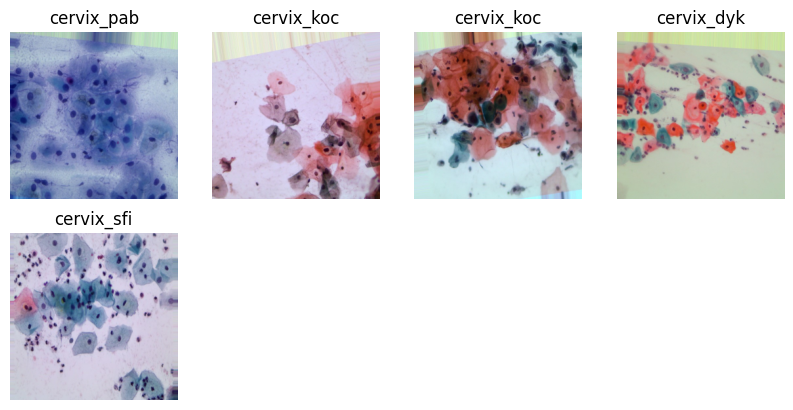

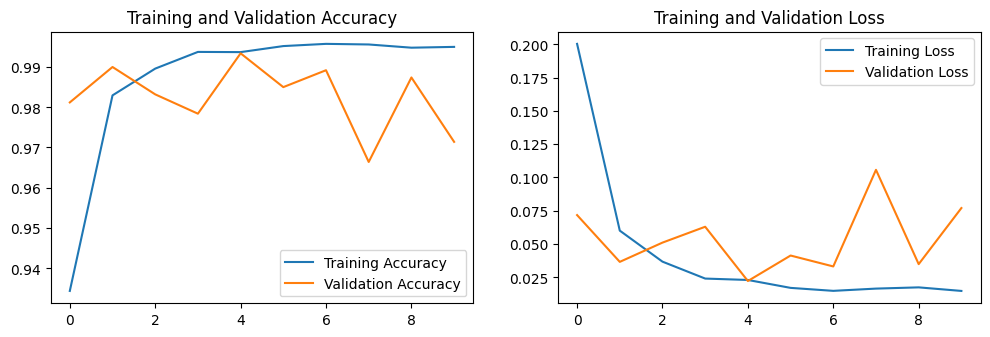

157/157 [==============================] - 16s 100ms/step - loss: 0.0770 - tp: 4856.0000 - fp: 140.0000 - tn: 19860.0000 - fn: 144.0000 - precision: 0.9720 - recall: 0.9712 - accuracy: 0.9714 - auc: 0.9985
Accuracy on the Test Set = 97.14 %
True Positives = 4856.0. True Negatives = 19860.0
False Positives = 140.0. False Negatives = 144.0
Precision = 0.9719775915145874
Recall = 0.9711999893188477
F1 Score = 97.15886348300174
ROC AUC = 0.9984927773475647
Model Saved!
True :  [0 0 0 ... 4 4 4]
157/157 [==============================] - 16s 96ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

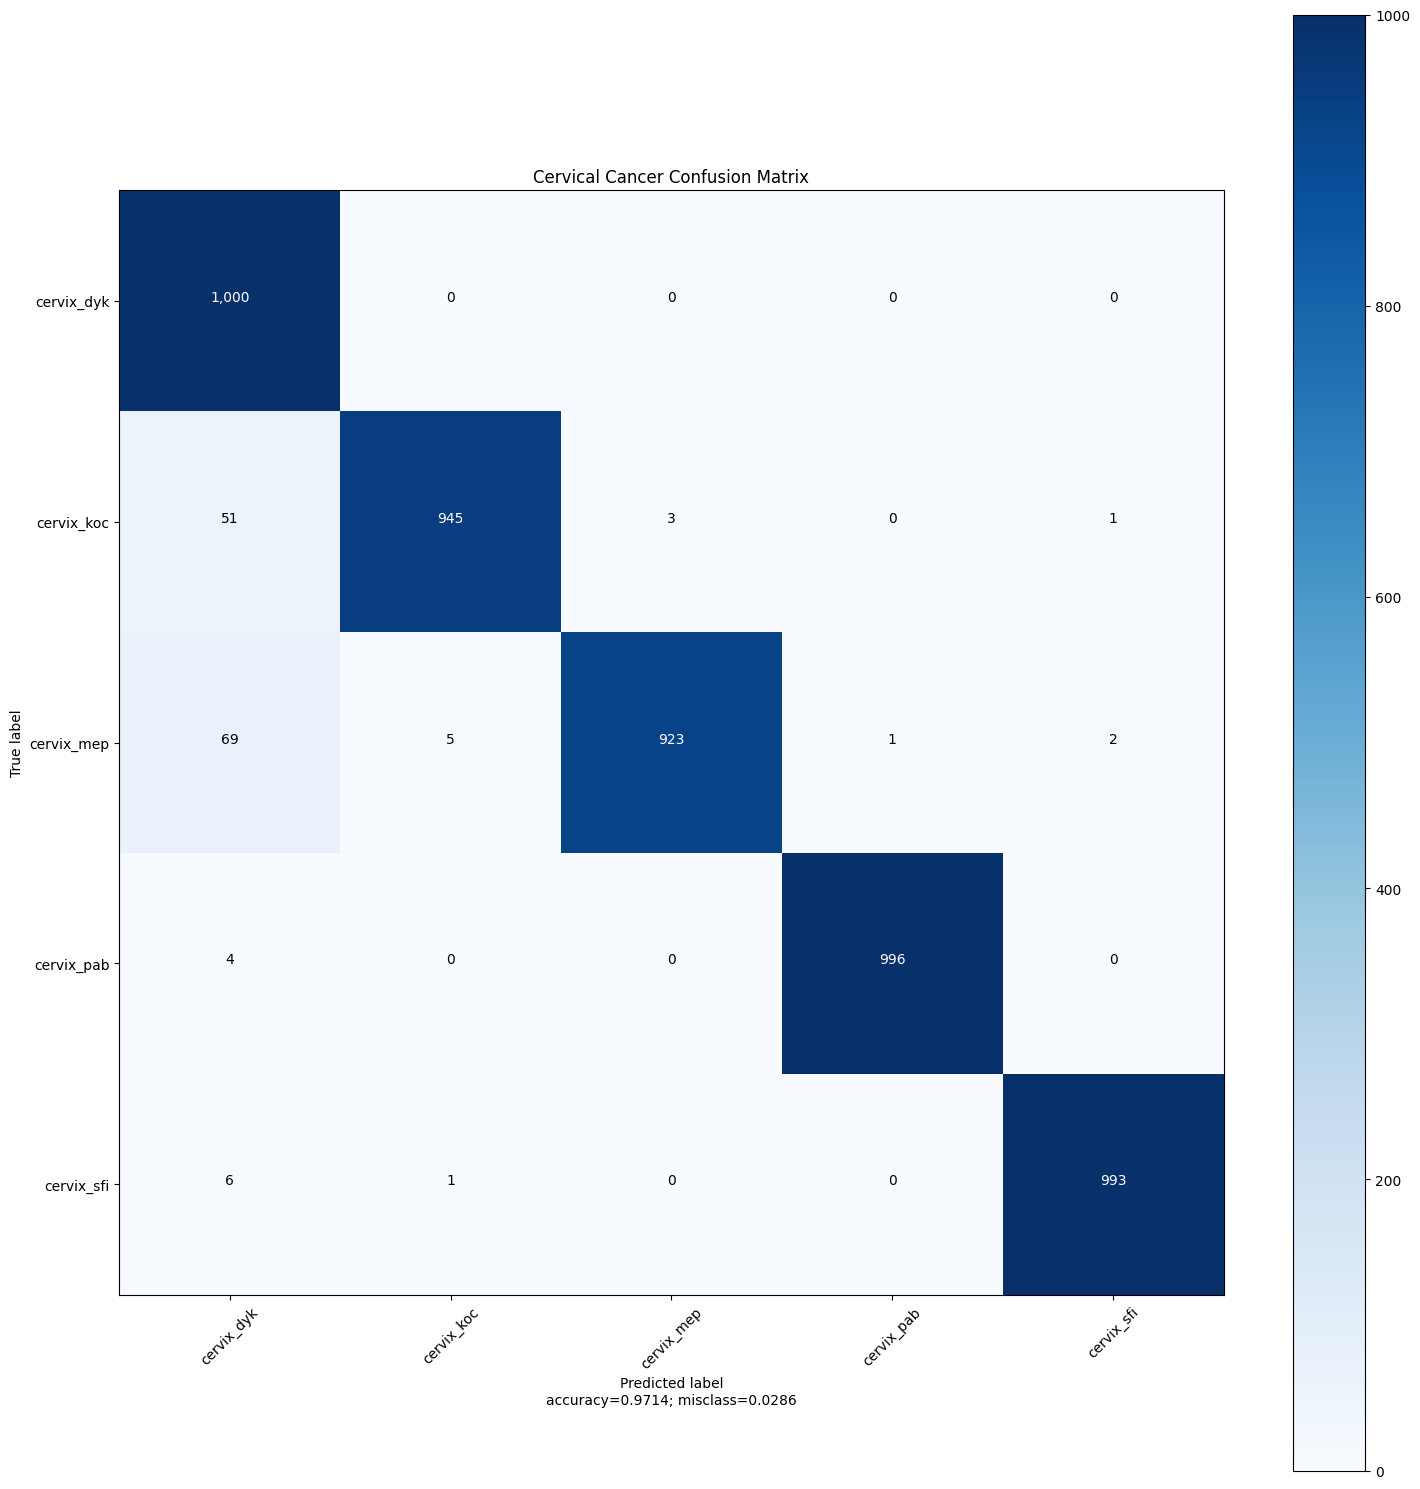

Best Hyperparameters (learning rate, batch size): [9.95284166e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [34]:
className = 'Cervical Cancer '
cpath = os.path.join(mpath, 'Cervical Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel2(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 25000 files belonging to 5 classes.

For Training :  Found 20000 images belonging to 5 classes.

For Val :  Found 5000 images belonging to 5 classes.

No of Classes :  5
Classes :  ['colon_aca', 'colon_bnt', 'lung_aca', 'lung_bnt', 'lung_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_1[0][0]']       

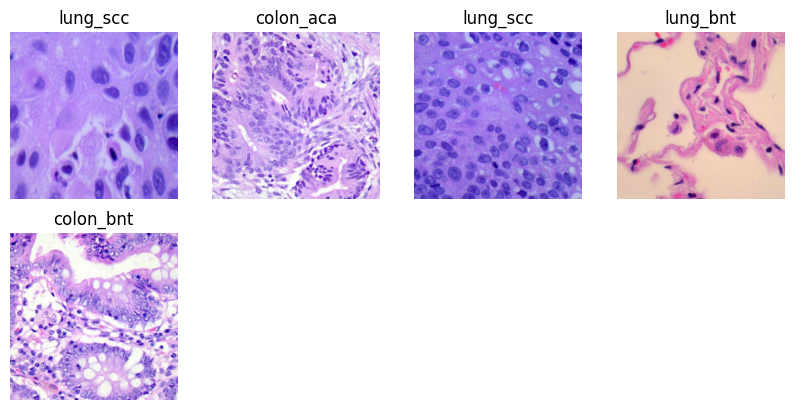

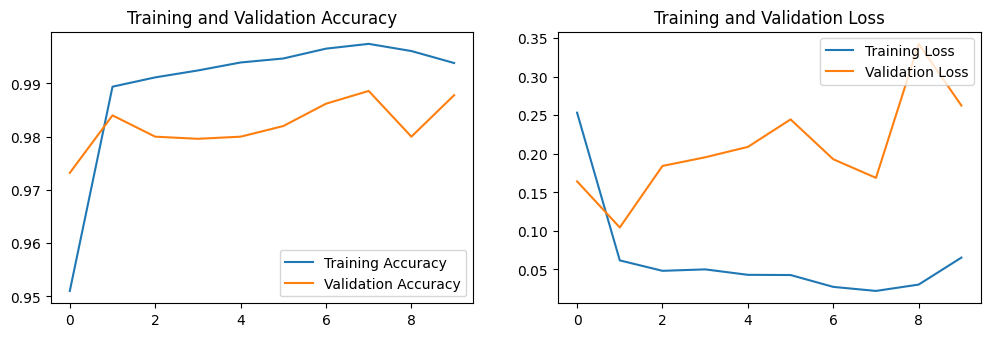

157/157 [==============================] - 16s 102ms/step - loss: 0.2625 - tp: 4939.0000 - fp: 61.0000 - tn: 19939.0000 - fn: 61.0000 - precision: 0.9878 - recall: 0.9878 - accuracy: 0.9878 - auc: 0.9939
Accuracy on the Test Set = 98.78 %
True Positives = 4939.0. True Negatives = 19939.0
False Positives = 61.0. False Negatives = 61.0
Precision = 0.9878000020980835
Recall = 0.9878000020980835
F1 Score = 98.78000020980835
ROC AUC = 0.9939015507698059
Model Saved!
True :  [0 0 0 ... 4 4 4]
157/157 [==============================] - 19s 116ms/step
Predicted :  [0 0 0 ... 4 4 4]


<Figure size 640x480 with 0 Axes>

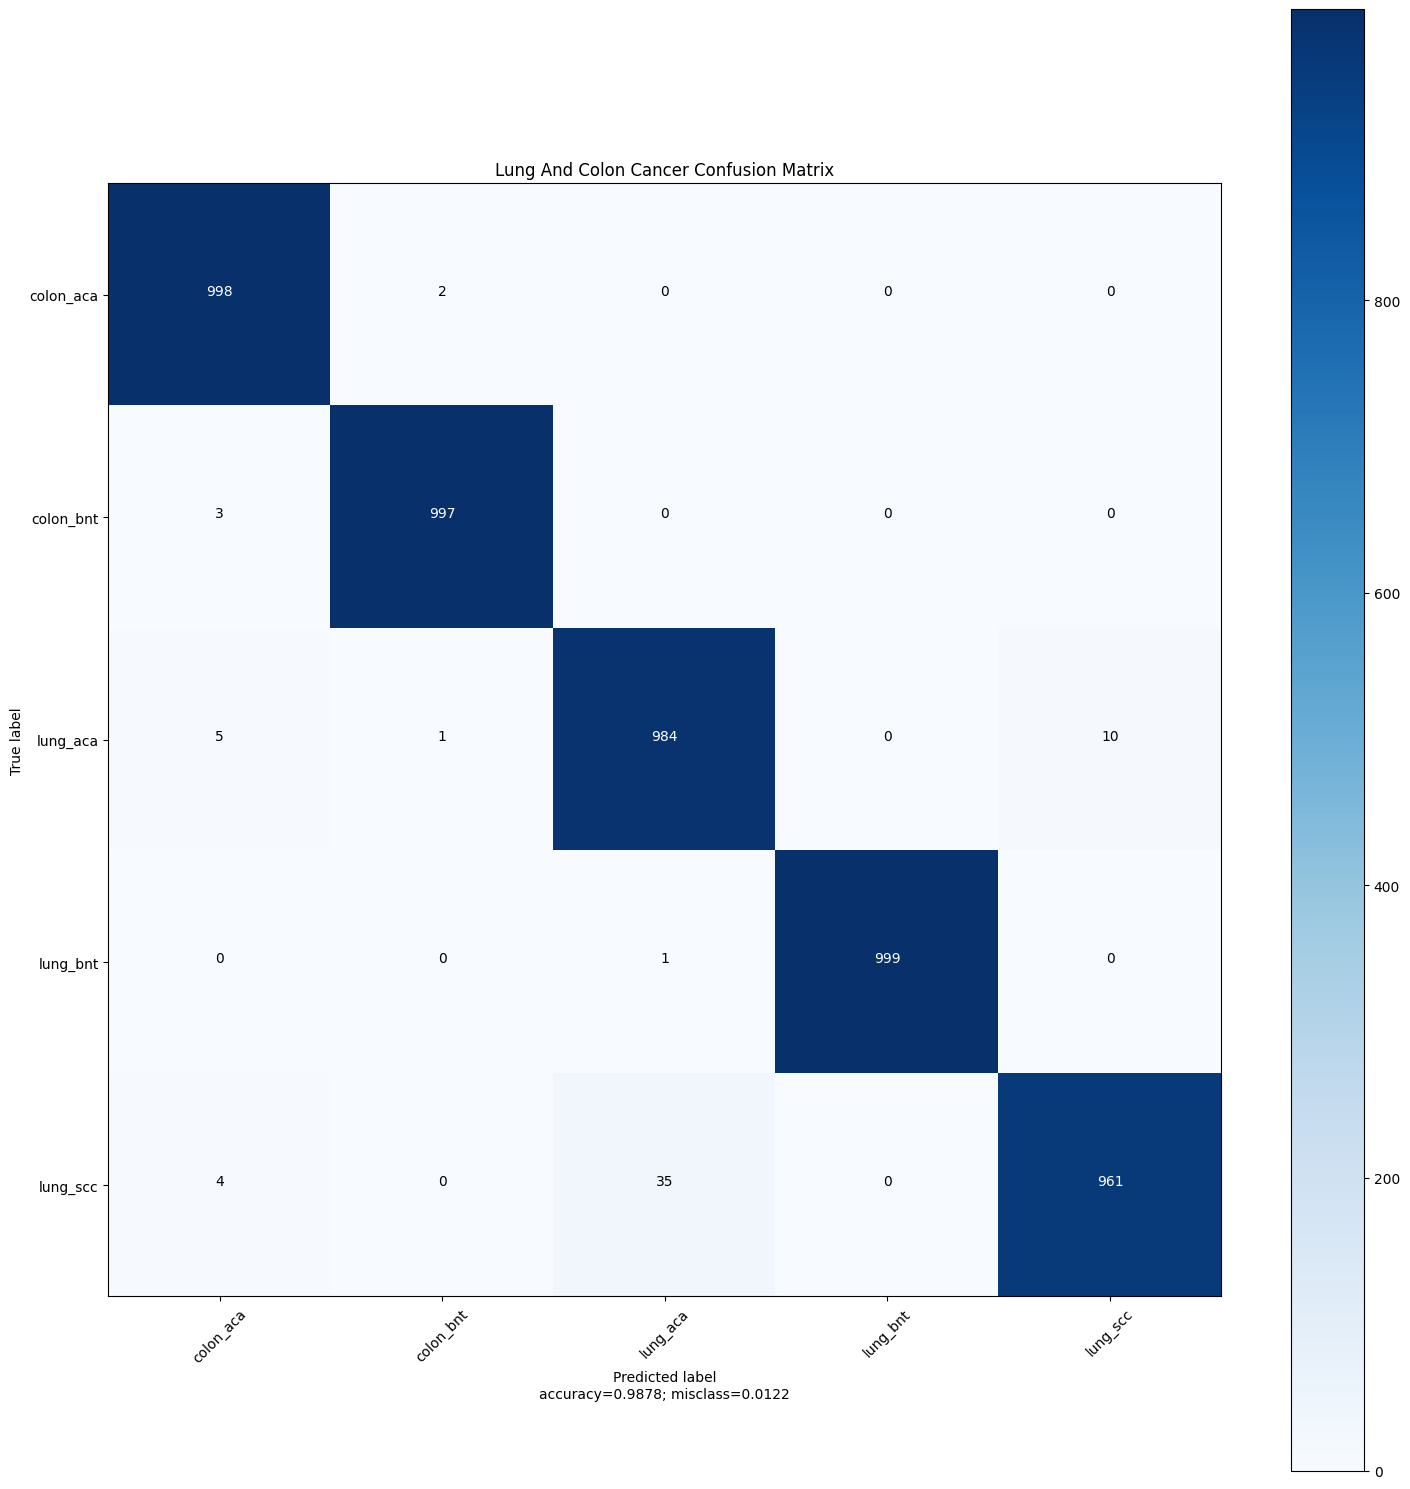

Best Hyperparameters (learning rate, batch size): [9.95284765e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [35]:
className = 'Lung And Colon Cancer '
cpath = os.path.join(mpath, 'Lung and Colon Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)

In [ ]:
className = 'Oral Cancer '
cpath = os.path.join(mpath, 'Oral Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel2(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10002 files belonging to 2 classes.

For Training :  Found 8002 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['oral_normal', 'oral_scc']
Image Shape :  (32, 256, 256, 3)
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_9 (Rescaling)     (None, 224, 224, 3)          0         ['input_10[0][0]']            
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_9[0][0]']         
                                 


Total :  Found 20000 files belonging to 4 classes.

For Training :  Found 16000 images belonging to 4 classes.

For Val :  Found 4000 images belonging to 4 classes.

No of Classes :  4
Classes :  ['all_benign', 'all_early', 'all_pre', 'all_pro']
Image Shape :  (32, 256, 256, 3)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 224, 224, 3)          0         ['input_4[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_3[0][0]']         
          

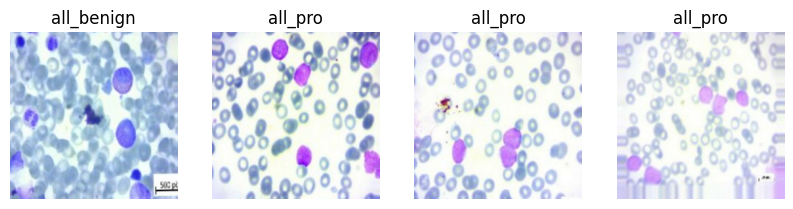

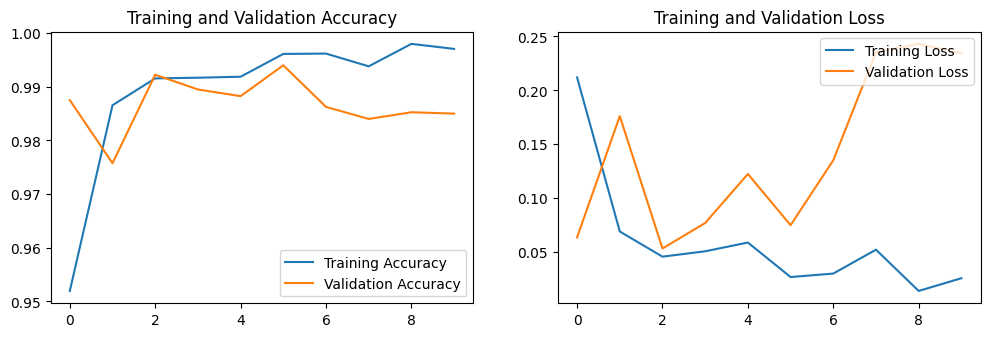

125/125 [==============================] - 12s 92ms/step - loss: 0.2343 - tp: 3940.0000 - fp: 60.0000 - tn: 11940.0000 - fn: 60.0000 - precision: 0.9850 - recall: 0.9850 - accuracy: 0.9850 - auc: 0.9930
Accuracy on the Test Set = 98.50 %
True Positives = 3940.0. True Negatives = 11940.0
False Positives = 60.0. False Negatives = 60.0
Precision = 0.9850000143051147
Recall = 0.9850000143051147
F1 Score = 98.50000143051147
ROC AUC = 0.9929863214492798
Model Saved!
True :  [0 0 0 ... 3 3 3]
125/125 [==============================] - 12s 91ms/step
Predicted :  [0 0 0 ... 3 3 3]


<Figure size 640x480 with 0 Axes>

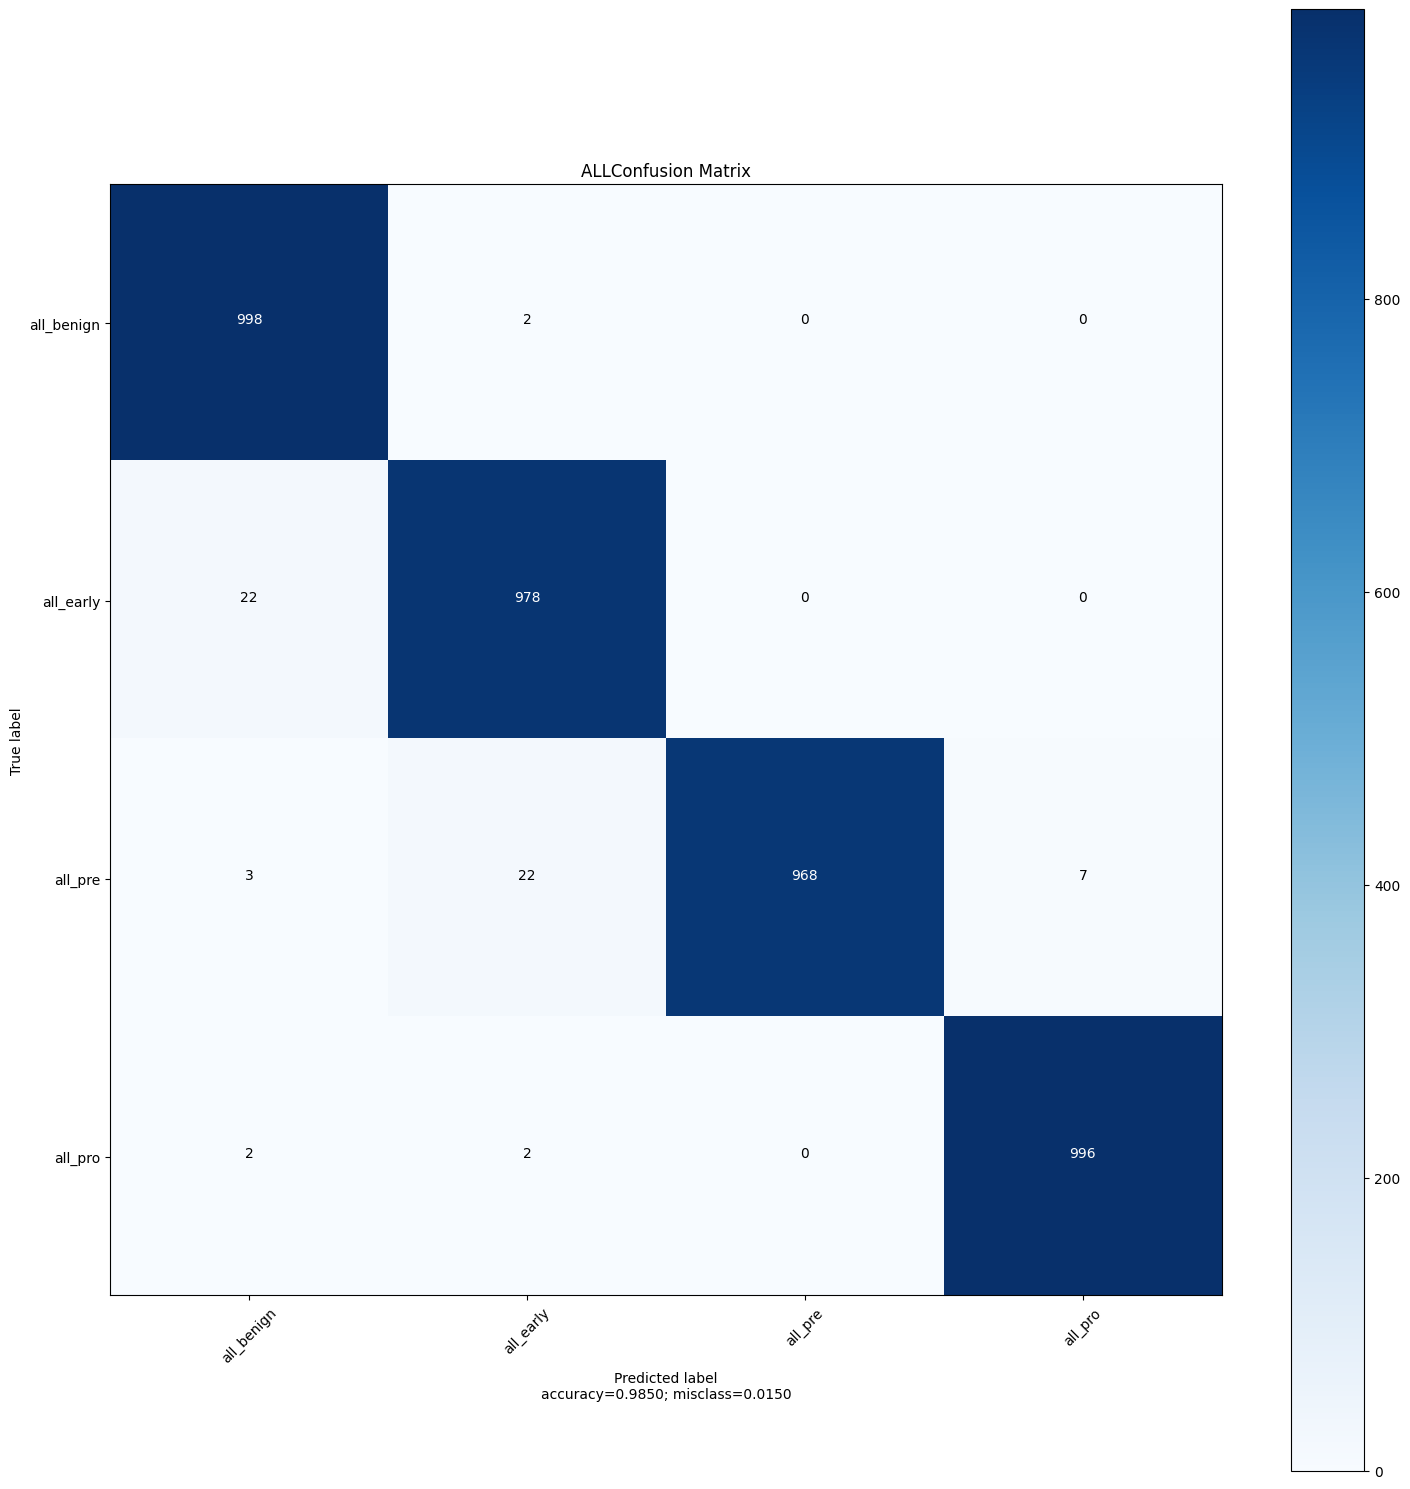

Best Hyperparameters (learning rate, batch size): [9.95284138e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [37]:
className = 'ALL'
cpath = os.path.join(mpath, 'ALL')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_8 (Rescaling)     (None, 224, 224, 3)          0         ['input_9[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_8[0][0]']         
                           

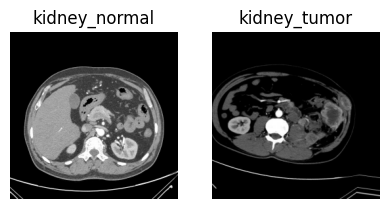

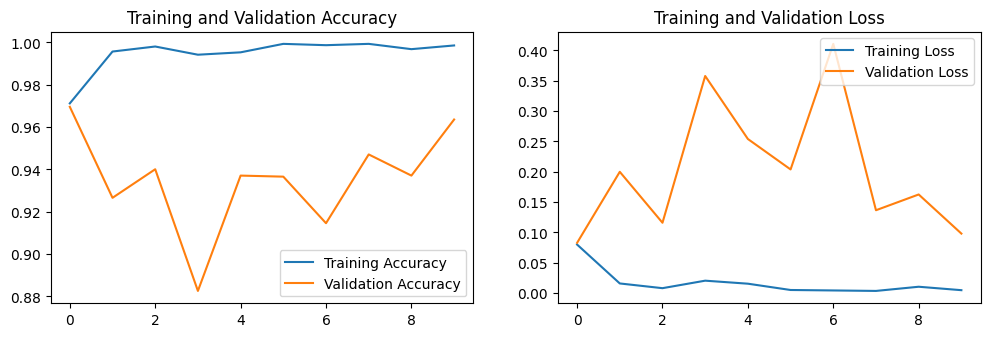

63/63 [==============================] - 6s 88ms/step - loss: 0.0978 - tp: 1927.0000 - fp: 73.0000 - tn: 1927.0000 - fn: 73.0000 - precision: 0.9635 - recall: 0.9635 - accuracy: 0.9635 - auc: 0.9944
Accuracy on the Test Set = 96.35 %
True Positives = 1927.0. True Negatives = 1927.0
False Positives = 73.0. False Negatives = 73.0
Precision = 0.9635000228881836
Recall = 0.9635000228881836
F1 Score = 96.35000228881836
ROC AUC = 0.9943963289260864
Model Saved!
True :  [0 0 0 ... 1 1 1]
63/63 [==============================] - 7s 91ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

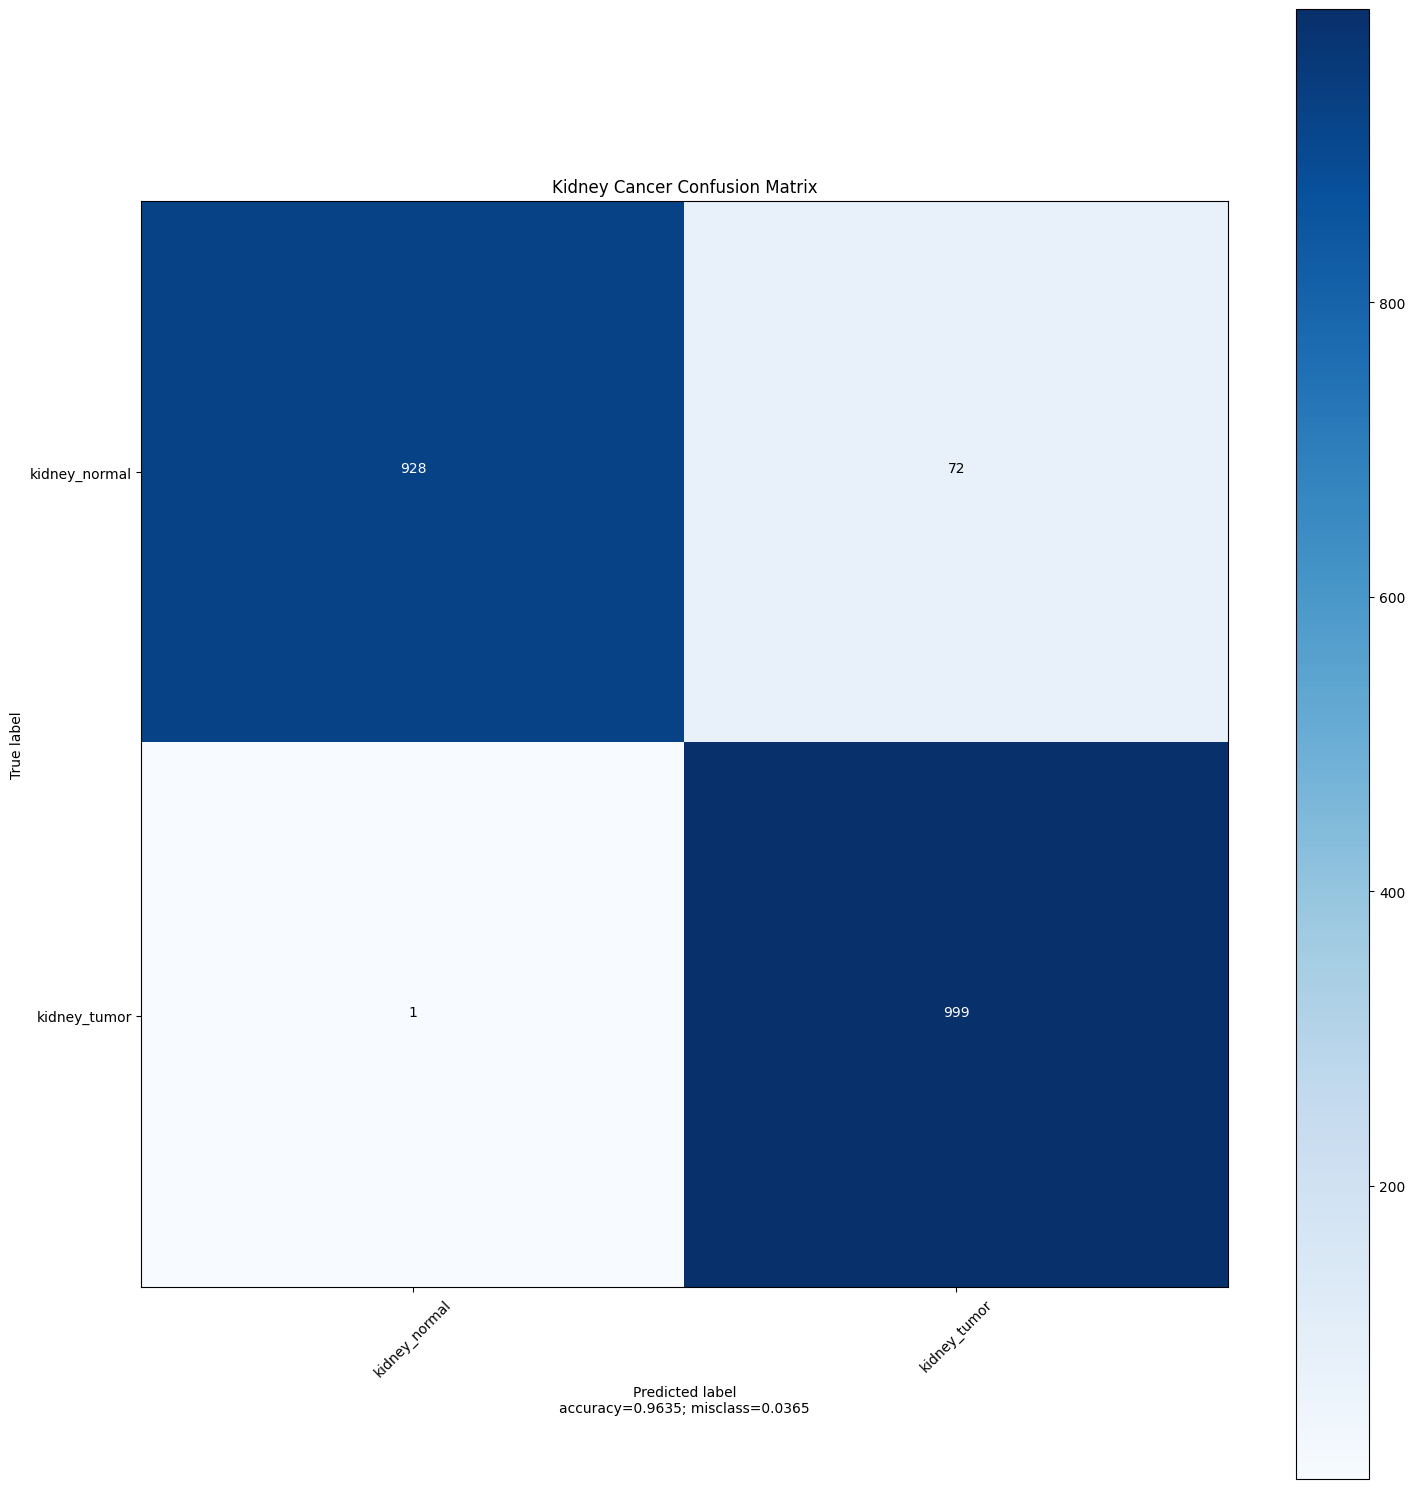

Best Hyperparameters (learning rate, batch size): [9.95284181e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [42]:
className = 'Kidney Cancer '
cpath = os.path.join(mpath, 'Kidney Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel2(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 10000 files belonging to 2 classes.

For Training :  Found 8000 images belonging to 2 classes.

For Val :  Found 2000 images belonging to 2 classes.

No of Classes :  2
Classes :  ['breast_benign', 'breast_malignant']
Image Shape :  (32, 256, 256, 3)
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_5[0][0]']         
                       

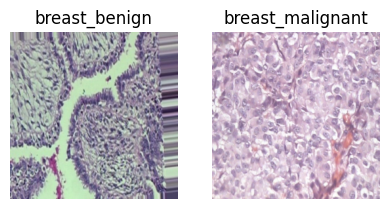

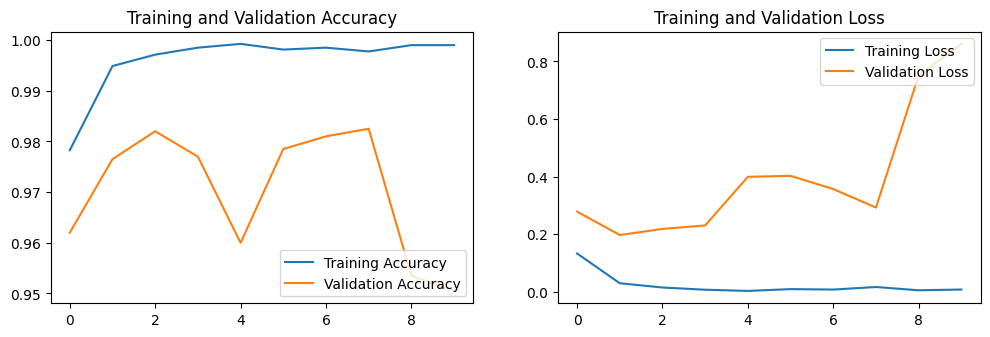

63/63 [==============================] - 14s 216ms/step - loss: 0.8603 - tp: 1901.0000 - fp: 99.0000 - tn: 1901.0000 - fn: 99.0000 - precision: 0.9505 - recall: 0.9505 - accuracy: 0.9505 - auc: 0.9595
Accuracy on the Test Set = 95.05 %
True Positives = 1901.0. True Negatives = 1901.0
False Positives = 99.0. False Negatives = 99.0
Precision = 0.9505000114440918
Recall = 0.9505000114440918
F1 Score = 95.05000114440918
ROC AUC = 0.9595217108726501
Model Saved!
True :  [0 0 0 ... 1 1 1]
63/63 [==============================] - 14s 218ms/step
Predicted :  [0 0 0 ... 1 1 1]


<Figure size 640x480 with 0 Axes>

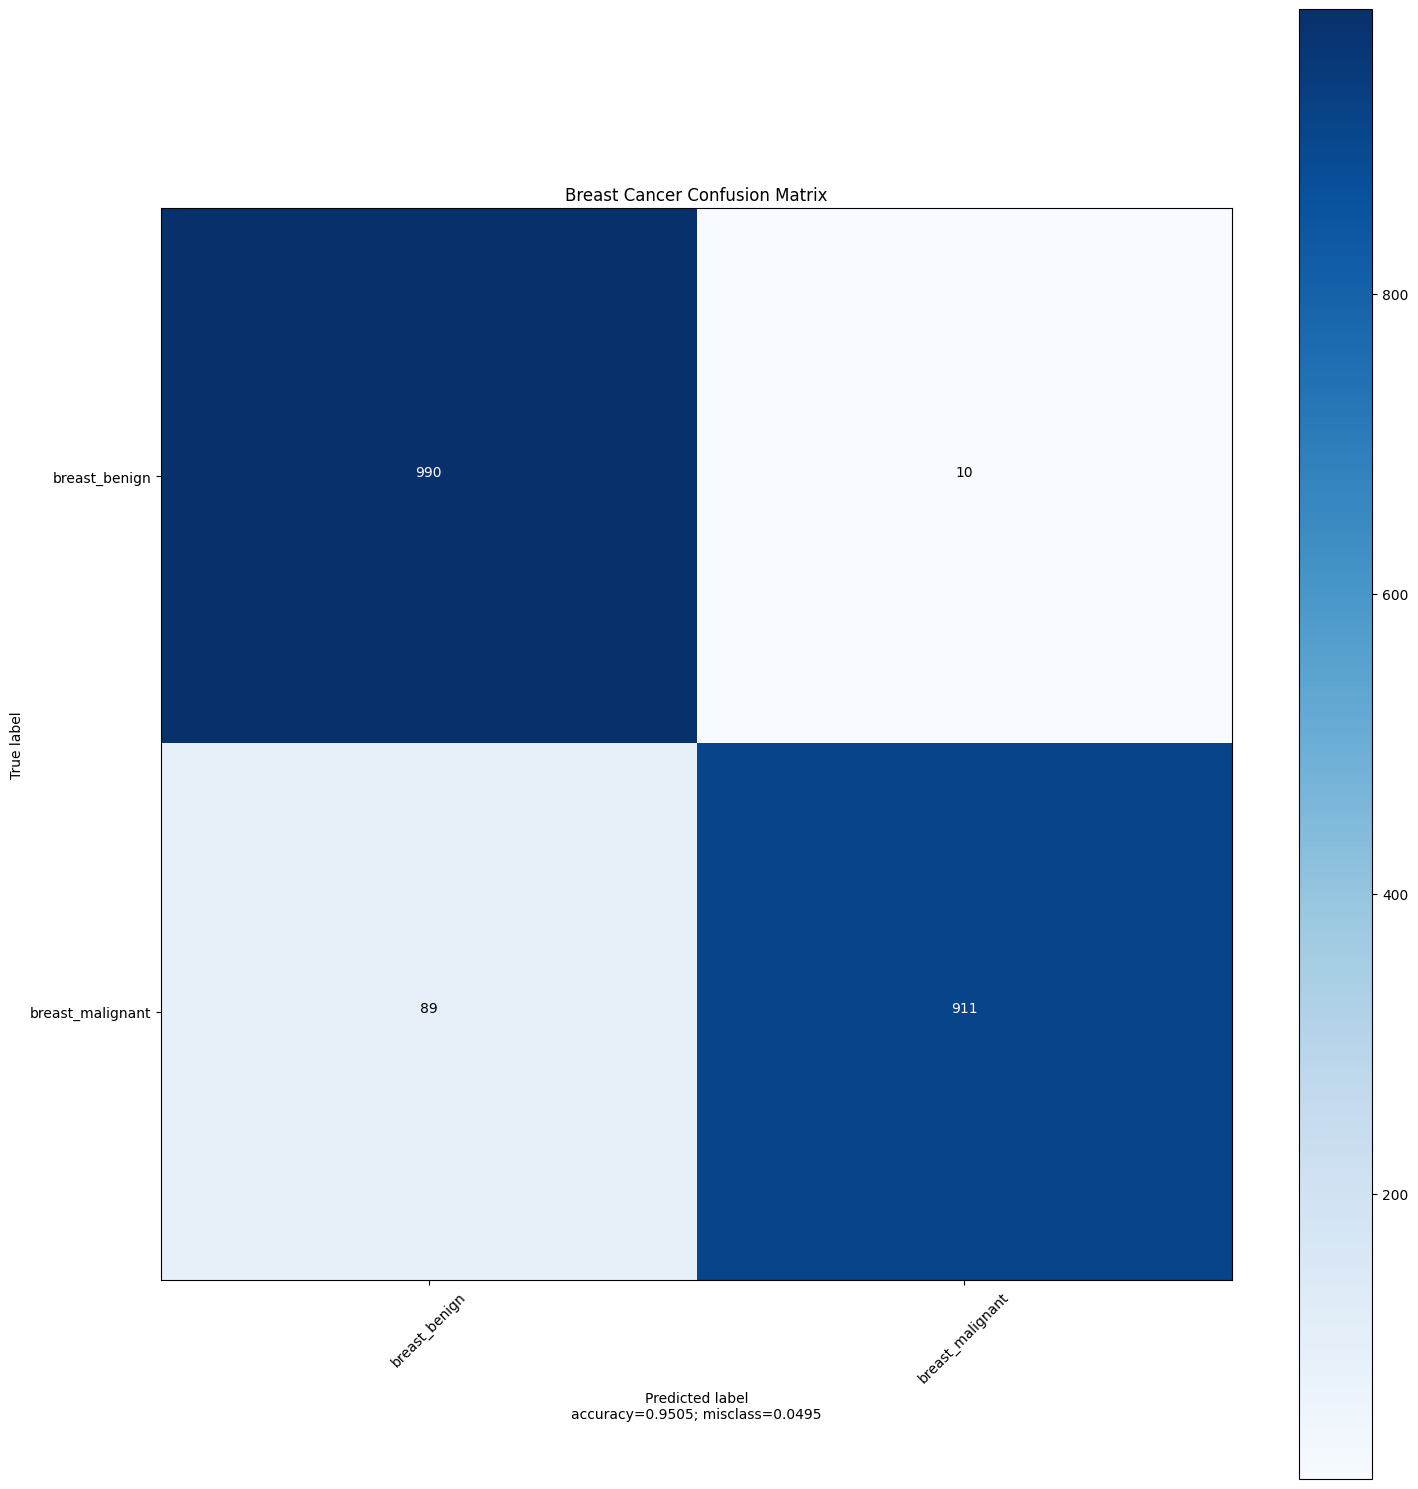

Best Hyperparameters (learning rate, batch size): [9.95285364e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [39]:
className = 'Breast Cancer '
cpath = os.path.join(mpath, 'Breast Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['lymph_cll', 'lymph_fl', 'lymph_mcl']
Image Shape :  (32, 256, 256, 3)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 224, 224, 3)          0         ['input_7[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_6[0][0]']         
                     

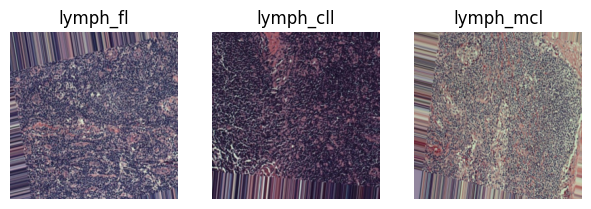

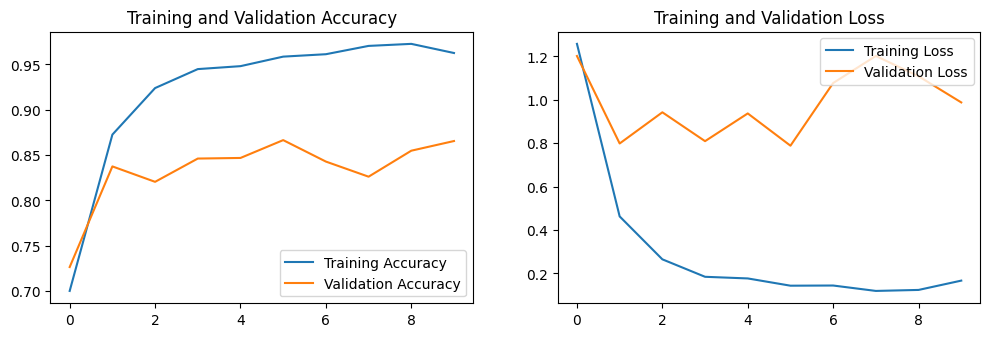

94/94 [==============================] - 11s 120ms/step - loss: 0.9875 - tp: 2596.0000 - fp: 403.0000 - tn: 5597.0000 - fn: 404.0000 - precision: 0.8656 - recall: 0.8653 - accuracy: 0.8653 - auc: 0.9395
Accuracy on the Test Set = 86.53 %
True Positives = 2596.0. True Negatives = 5597.0
False Positives = 403.0. False Negatives = 404.0
Precision = 0.8656218647956848
Recall = 0.8653333187103271
F1 Score = 86.54775677030352
ROC AUC = 0.9395308494567871
Model Saved!
True :  [0 0 0 ... 2 2 2]
94/94 [==============================] - 12s 122ms/step
Predicted :  [0 0 2 ... 2 1 1]


<Figure size 640x480 with 0 Axes>

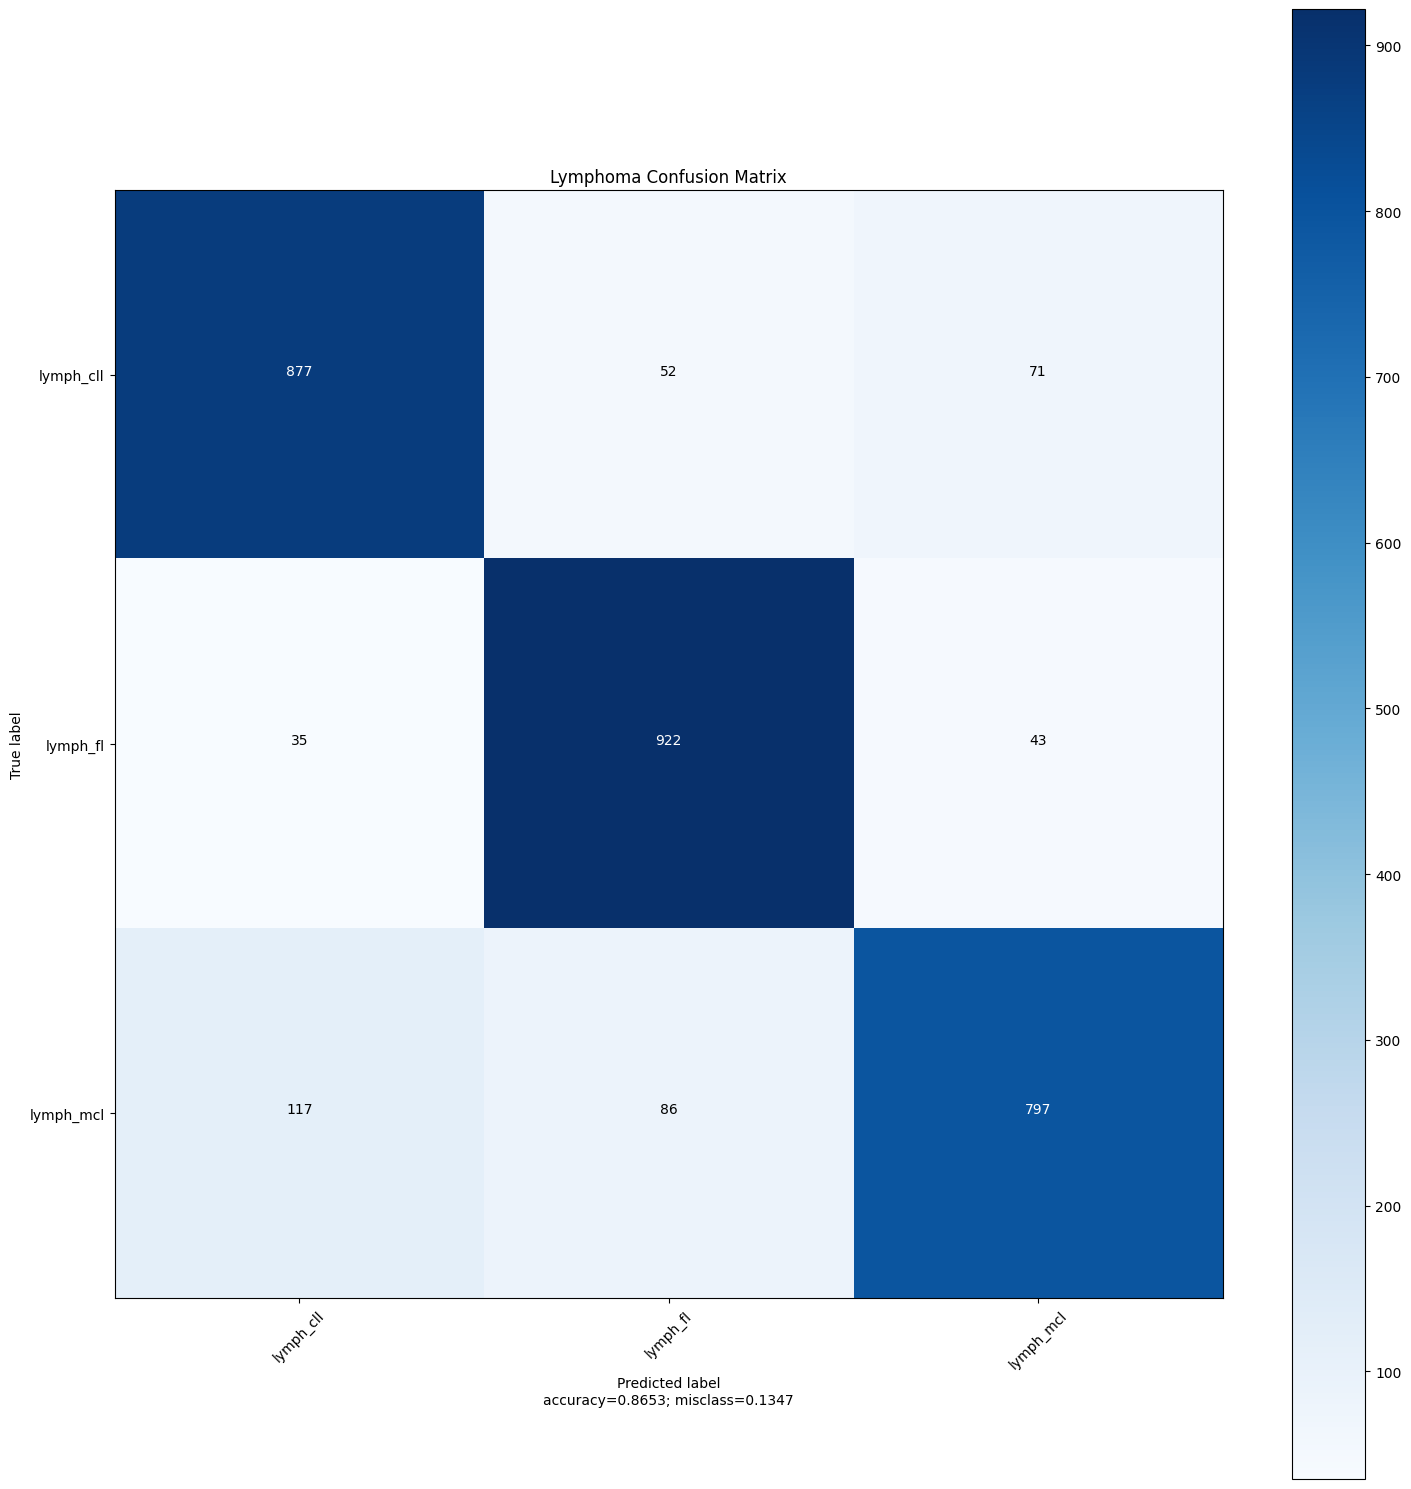

Best Hyperparameters (learning rate, batch size): [9.95284969e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [40]:
className = 'Lymphoma '
cpath = os.path.join(mpath, 'Lymphoma')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)


Total :  Found 15000 files belonging to 3 classes.

For Training :  Found 12000 images belonging to 3 classes.

For Val :  Found 3000 images belonging to 3 classes.

No of Classes :  3
Classes :  ['brain_glioma', 'brain_menin', 'brain_tumor']
Image Shape :  (32, 256, 256, 3)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 224, 224, 3)          0         ['input_8[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling_7[0][0]']         
             

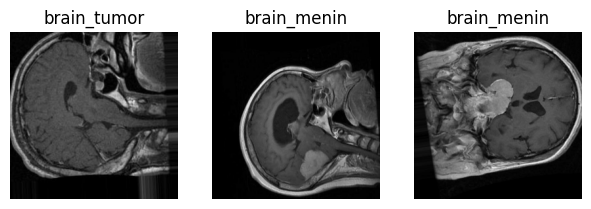

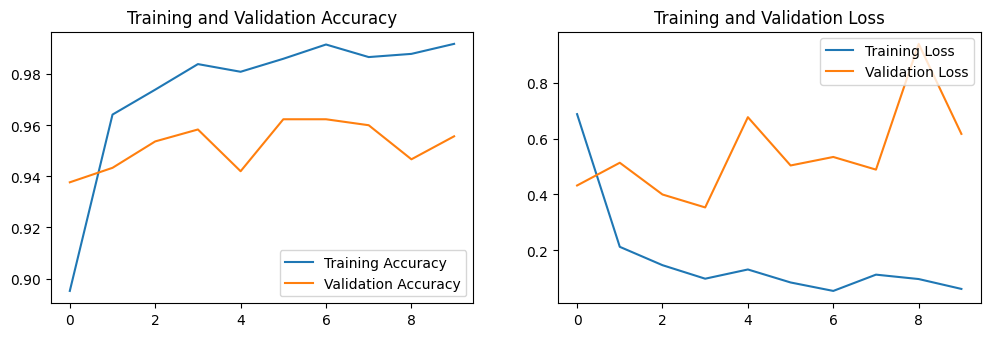

94/94 [==============================] - 8s 85ms/step - loss: 0.6169 - tp: 2867.0000 - fp: 133.0000 - tn: 5867.0000 - fn: 133.0000 - precision: 0.9557 - recall: 0.9557 - accuracy: 0.9557 - auc: 0.9767
Accuracy on the Test Set = 95.57 %
True Positives = 2867.0. True Negatives = 5867.0
False Positives = 133.0. False Negatives = 133.0
Precision = 0.9556666612625122
Recall = 0.9556666612625122
F1 Score = 95.56666612625122
ROC AUC = 0.9766806960105896
Model Saved!
True :  [0 0 0 ... 2 2 2]
94/94 [==============================] - 9s 89ms/step
Predicted :  [0 0 0 ... 2 2 2]


<Figure size 640x480 with 0 Axes>

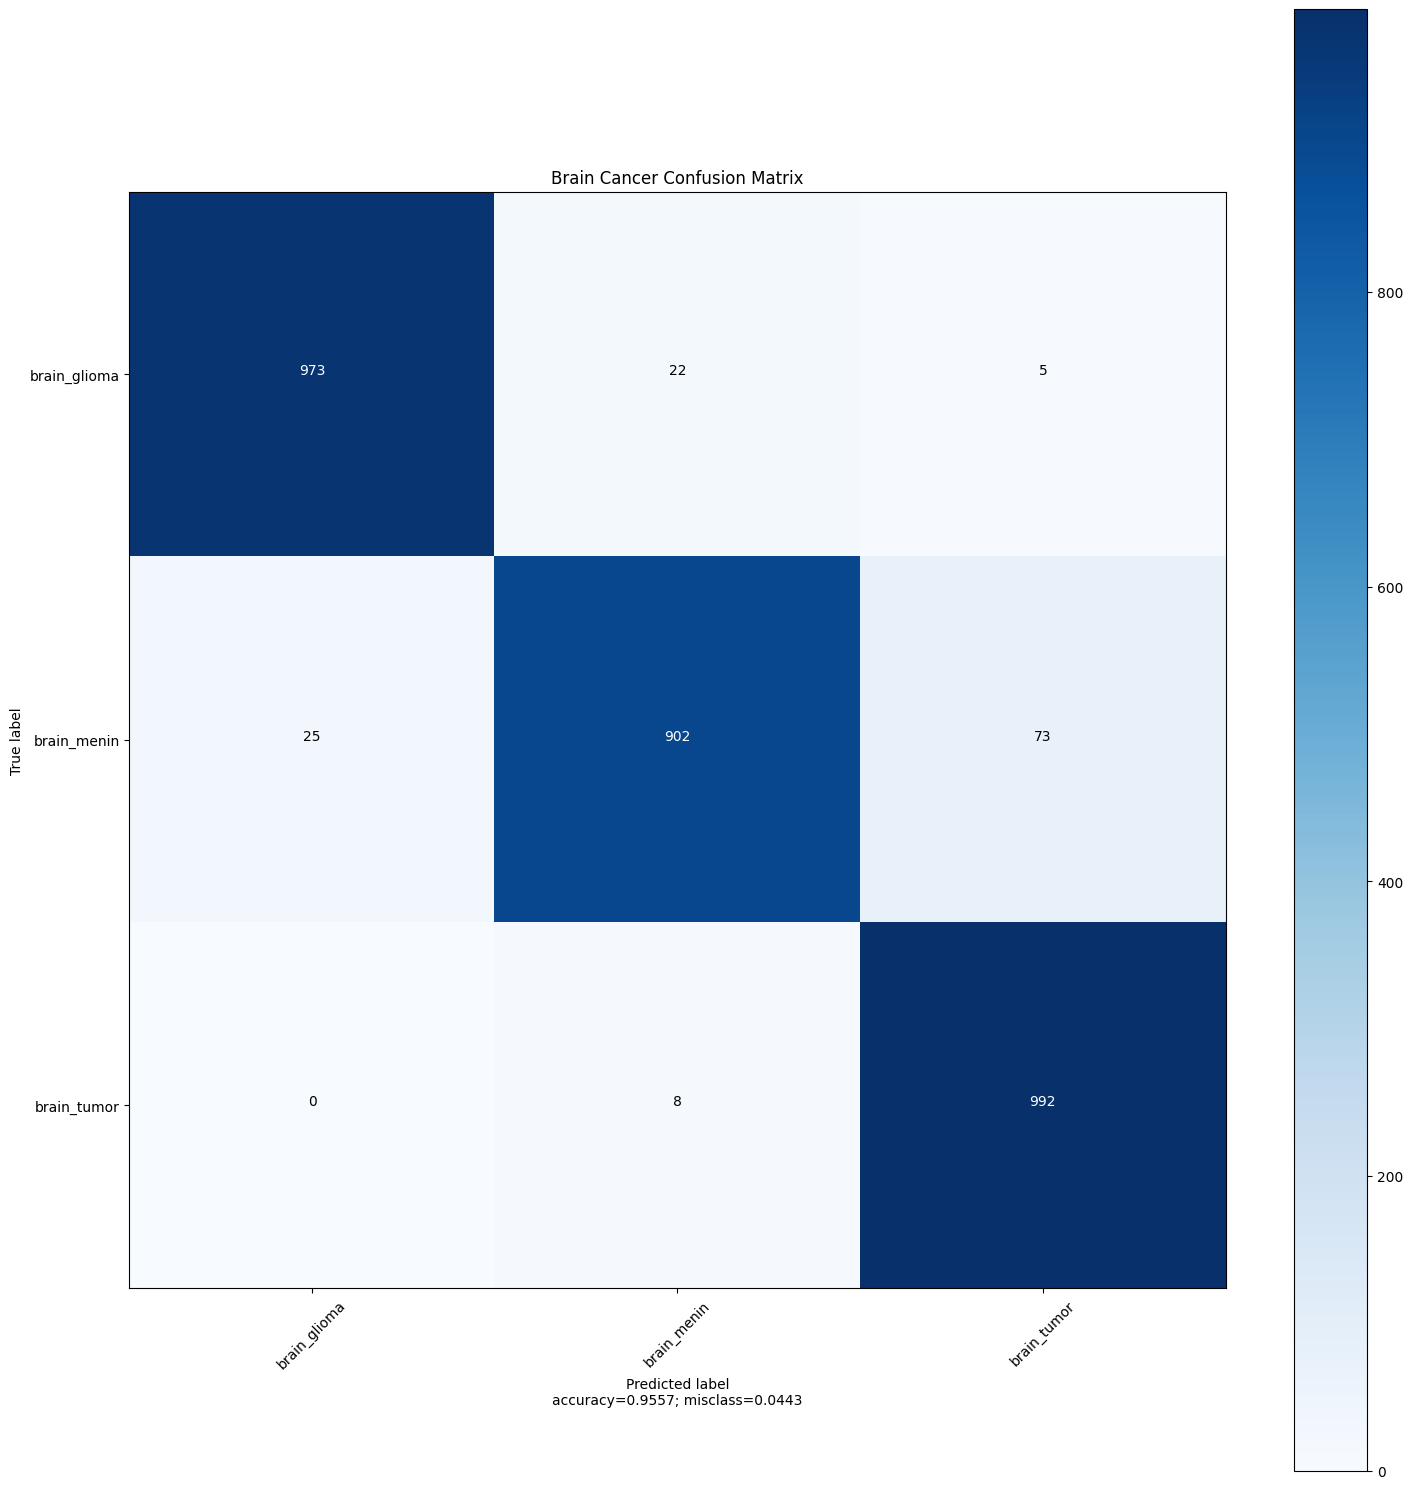

Best Hyperparameters (learning rate, batch size): [9.95285478e-03 2.55999963e+02]


/tmp/ipykernel_34/1764077853.py:22: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, x0=np.random.rand(2), bounds=search_space, method='Powell')


<Figure size 640x480 with 0 Axes>

In [41]:
className = 'Brain Cancer '
cpath = os.path.join(mpath, 'Brain Cancer')
noOfClasses, class_names, train_generator, validation_generator = initiateGenerator(cpath)
curModel = initiateModel(noOfClasses)
modelSummary(curModel)
curModel, annealer, checkpoint = initiateParams(className, curModel, lr)
curHistory = modelFit(curModel, annealer, checkpoint, train_generator, validation_generator)
plotOutput(curHistory, className, gEpochs)
evalModel(curModel)
saveModel(curModel, className)
callPlot(curModel, className, class_names)